# Attention Architecture

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import music21

In [3]:
# from fastai.text import *
from enum import Enum
import torch

In [4]:
import numpy as np
import torch.nn as nn

In [5]:
np.set_printoptions(edgeitems=10, threshold=40, linewidth=200)

In [6]:
import sys
sys.path.insert(0, '../../')
from src.fastai_data import *
from src.encode_data import *
from src.serve import *

In [7]:
from src.music_transformer import *

In [8]:
from src.unilm import *

In [9]:
config = unilm_config(vocab)

In [10]:
# # config['n_layers'] = 8
# # config['dec_layers'] = 0
# config['n_layers'] = 2
# config['dec_layers'] = 2
# config['mem_len'] = 512
# config['rand_bptt'] = False
# config['bptt'] = 512
# config['bs'] = 8


In [11]:
config

{'ctx_len': 150,
 'n_layers': 8,
 'n_heads': 8,
 'd_model': 512,
 'd_head': 64,
 'd_inner': 2048,
 'resid_p': 0.1,
 'attn_p': 0.1,
 'ff_p': 0.1,
 'embed_p': 0.1,
 'output_p': 0.1,
 'bias': False,
 'scale': True,
 'act': <Activation.GeLU: 3>,
 'double_drop': True,
 'tie_weights': True,
 'out_bias': True,
 'init': <function fastai.text.models.transformer.init_transformer(m)>,
 'mem_len': 512,
 'mask': True,
 'pad_idx': 1,
 'bos_idx': 0,
 'sep_idx': 8,
 'transpose_range': (0, 12),
 'rand_transpose': True,
 'rand_bptt': False,
 'note_range': (9, 137),
 'bs': 16,
 'bptt': 256,
 'vocab_size': 312,
 'dec_layers': 8}

In [12]:
base_path = Path('../../data/midi/v16/sf4/')

In [13]:
cache_name = 'tmp/hook_c'
# cache_name = 'tmp/sample'

## BERT Dataloading

In [14]:
ns_dl_tfms = [mask_tfm, next_sentence_tfm]
ns_config = config.copy()
ns_config['bs'] *= 2
ns_data = load_music_data(base_path/'piano_duet', cache_name=cache_name, vocab=vocab, 
                          y_offset=0, dl_tfms=ns_dl_tfms, **ns_config)

In [15]:
xb,yb = ns_data.one_batch(); [x.shape for x in xb+yb]

[torch.Size([32, 256]),
 torch.Size([32, 256]),
 torch.Size([32, 256]),
 torch.Size([32, 256])]

## S2S Dataloading

In [16]:
s2s_dl_tfms = [s2s_tfm]
s2s_data = MusicDataBunch.load(base_path/'s2s_encode', cache_name=cache_name, 
                           preloader_cls=S2SPreloader, dl_tfms=s2s_dl_tfms, y_offset=1,
                           shuffle_dl=True, **config)


In [17]:
s2s_data.train_dl.dl.dataset.on_epoch_begin()
s2s_data.train_dl.dl.dataset.on_epoch_end()
xb,yb = s2s_data.one_batch(); [x.shape for x in xb+yb]

[torch.Size([16, 256]),
 torch.Size([16, 256]),
 torch.Size([16, 256]),
 torch.Size([16, 256]),
 torch.Size([16, 256])]

### Load NextWord dataset (Language Model)

In [18]:

def nw_2_tfm(b):
    x,y_nw = b
    x_mask,y_mask = mask_tfm((x,x), mask_last=True)
#     all_pad = torch.full_like(x, vocab.pad_idx)
#     return (x_mask,torch.full_like(x, TaskType.NextWord.value),all_pad),(y_mask,y_nw) 
    return (x_mask,torch.full_like(x, TaskType.NextWord.value),x),(y_mask,y_nw) 
    

In [19]:

nw_data = MusicDataBunch.load(base_path/'piano_duet', cache_name=cache_name, 
                              vocab=vocab, dl_tfms=[nw_2_tfm], y_offset=1, 
                              train_tfms=[to_single_stream], valid_tfms=[to_single_stream], **config)

## Datasets

In [20]:
datasets = [nw_data, s2s_data, ns_data]
# datasets = [nw_data]

In [21]:
ns_data.train_dl

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7fa7dc0b9080>, device=device(type='cuda'), tfms=[<function mask_tfm at 0x7fa7dc12c6a8>, <function next_sentence_tfm at 0x7fa7dc12c620>], collate_fn=<function data_collate at 0x7fa7e6d267b8>)

## Load

In [22]:
def predict_func(parts): return [p if idx == 1 else F.softmax(p, dim=-1) for idx,p in enumerate(parts)]
# Need to monkey patch pred_batch activation function for 2d array
loss_func_name = camel2snake(BertLoss.__name__)
basic_train.loss_func_name2activ[loss_func_name] = predict_func

In [23]:
loss_func = BertLoss(loss_mult=(1,1,1,1))
learn = bert_model_learner(datasets[0], config.copy(), 
                           loss_func=loss_func)

# model = get_bert_model(config['vocab_size'], config=config.copy())
# learn = BertLearner(datasets[0], model, config=config, split_func=None, loss_func=loss_func)

In [24]:
learn.metrics = [mask_acc, nw_acc, s2s_acc, ns_acc]

In [25]:
from fastai.callbacks.rnn import RNNTrainer
learn.callbacks = [c for c in learn.callbacks if not isinstance(c, RNNTrainer)]
learn.callbacks.append(BertTrainer(learn, datasets))

In [26]:
[type(c) for c in learn.callbacks]

[src.unilm.BertTrainer]

In [27]:
learn = learn.to_fp16()

### Training

In [28]:
# learn.fit_one_cycle(12, 1e-4)

## Load existing

In [29]:
base_path/'models/unilm'

PosixPath('../../data/midi/v16/sf4/models/unilm')

In [30]:
saved_models = get_files(base_path/'piano_duet/models/unilm', recurse=True, extensions=['.pth']); saved_models

[PosixPath('../../data/midi/v16/sf4/piano_duet/models/unilm/hq/4_ep90_best.pth'),
 PosixPath('../../data/midi/v16/sf4/piano_duet/models/unilm/hq/4_ep90.pth'),
 PosixPath('../../data/midi/v16/sf4/piano_duet/models/unilm/hq/3_ep30_full_best.pth'),
 PosixPath('../../data/midi/v16/sf4/piano_duet/models/unilm/hq/3_ep30_full.pth'),
 PosixPath('../../data/midi/v16/sf4/piano_duet/models/unilm/hook_c/1_ep60.pth'),
 PosixPath('../../data/midi/v16/sf4/piano_duet/models/unilm/hook_c/1_ep60_best.pth'),
 PosixPath('../../data/midi/v16/sf4/piano_duet/models/unilm/lq/1_ep30_best.pth'),
 PosixPath('../../data/midi/v16/sf4/piano_duet/models/unilm/lq/3_ep30_full_best.pth'),
 PosixPath('../../data/midi/v16/sf4/piano_duet/models/unilm/lq/1_ep30.pth'),
 PosixPath('../../data/midi/v16/sf4/piano_duet/models/unilm/lq/2_ep30_full_best.pth'),
 PosixPath('../../data/midi/v16/sf4/piano_duet/models/unilm/lq/3_ep30_full.pth')]

In [31]:
load_path = saved_models[5]
state = torch.load(load_path, map_location='cpu')
get_model(learn.model).load_state_dict(state['model'])
load_path

PosixPath('../../data/midi/v16/sf4/piano_duet/models/unilm/hook_c/1_ep60_best.pth')

## Prediction

Prediction algo

In [32]:
csv_path = base_path/f'piano_duet/piano_duet.csv'
csv = pd.read_csv(csv_path)
df = csv.loc[csv['numpy'].notna()];

# keywords = 'la bamba'.replace(' ', '|')
title_filter = df['title'].str.contains('la-bamba')==True
artist_filter = df['artist'].str.contains('')==True
results = df[title_filter & artist_filter]; results.head()
results = results[results.source == 'hooktheory_c']; results.head()

/home/ubuntu/anaconda3/envs/midi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,1,2,9,10,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,section,ht_key,song_url,midi,artist,md5,numpy,ht_offset,title,midi_title,parts,genres,mxl,source,ht_mode,ht_time_signature,ht_bpm
193208,chorus,C,https://www.hooktheory.com/theorytab/view/ritc...,midi_sources/hooktheory/pianoroll/r/ritchie-va...,ritchie-valen,aeee134e4034e5f98bb630c56d2f7f8c,sf4/piano_duet/hooktheory/pianoroll/r/ritchie-...,0.0,la-bamba,La Bamba,chorus,"Pop,Rock",NaN,hooktheory_c,1.0,4.0,144.0


In [33]:
idx = 0
file = base_path.parent/results.numpy.values[idx];
orig = base_path.parent/results.midi.values[idx];
file, orig

(PosixPath('../../data/midi/v16/sf4/piano_duet/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.npy'),
 PosixPath('../../data/midi/v16/midi_sources/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.mid'))

In [34]:
seed_len = 40
song_np = np.load(file)
seed_np = np.load(file)[:seed_len]
xb = torch.tensor(to_single_stream(seed_np, vocab=vocab))[None]
if torch.cuda.is_available(): xb = xb.cuda()

In [35]:
# seed_stream = npenc2stream(seed_np)
# seed_stream.show()

In [36]:
xb

tensor([[  0,   1,   8, 147,  64, 139,   8, 139,  66, 139,   8, 139,  68, 139,
           8, 139,  69, 141,  64, 145,  61, 145,  57, 145,   8, 141,  73, 139,
           8, 139,  76, 139,   8, 139,  74, 139,  69, 145,  66, 145,  62, 145,
           8, 139,  74, 139,   8, 139,  78, 139,   8, 139,  76, 141,   8, 139,
          59, 145,  56, 145,  52, 145,   8, 139,  64, 139,   8, 139,  68, 139,
           8, 139,  71, 139,   8, 139,  74, 139,  69, 145,  66, 145]],
       device='cuda:0')

In [37]:
# task_type = torch.full_like(xb, TaskType.NextWord.value)

# learn.model.reset()

# res = learn.pred_batch(batch=((xb,task_type,xb),xb)); res

# preds = loss_batch(learn.model.eval(), (xb,task_type,xb), yb); preds

In [38]:
# last = res[-1][0, -1]; last[143]
# idx = torch.multinomial(res[-1][0, -1], 1).item(); idx

In [39]:

def predict_nw(self, xb:Tensor, n_words:int=128):
    if xb.shape[0] > 1: xb = xb[0][None]
    seed = xb.cpu().numpy().squeeze()
    yb = torch.ones_like(xb)
    new_idx = []
#     self.mask = False
    self.model.reset()

    for i in progress_bar(range(n_words), leave=True):
#         print(xb)
        task_type = torch.full_like(xb, TaskType.NextWord.value)
        
        # Masking last - bert
#         mask_last = torch.cat((xb, torch.tensor(vocab.mask_idx, device=xb.device).view(1, 1)), dim=-1)
#         res = self.pred_batch(batch=((mask_last,task_type,mask_last),(yb)))[0][0, -1] # task1, task2 - (bs x ts x vocab)
        
        # Next Word
        res = self.pred_batch(batch=((xb,task_type,xb),xb))[-1][0, -1] # task1, task2 - (bs x ts x vocab)

        # Encoder only - nw
#         res = self.pred_batch(batch=((xb,task_type,xb),xb))[0][0, -1] # task1, task2 - (bs x ts x vocab)

        # Use first temperatures value if last prediction was duration
#         res.pow_(1 / (0.5))

        idx = torch.multinomial(res, 1).item()
    
        new_idx.append(idx)
#         t_idx = torch.tensor(idx, device=xb.device).view(1, 1)
#         xb = torch.cat((xb, t_idx), dim=-1)
        xb = xb.new_tensor([idx])[None]
        
#     self.mask = True
    return np.array(new_idx), seed


In [40]:
# vocab.itos[143]

In [41]:
# if xb.shape[0] > 1: xb = xb[0][None]
# seed = xb.cpu().numpy().squeeze()
# yb = torch.ones_like(xb)
# res = learn.pred_batch(batch=((xb, torch.full_like(xb, TaskType.NextWord.value),xb),(yb)))
# res[-1][0, -1][141]

In [42]:
out_s, seed_s = predict_nw(learn, xb, n_words=400)

In [43]:
vocab.textify(out_s)

'n53 d8 xxsep d2 n65 d2 xxsep d2 n64 d2 xxsep d2 n62 d2 xxsep d2 n60 d4 n55 d8 n52 d8 n48 d8 xxsep d4 n64 d2 xxsep d2 n67 d2 xxsep d2 n72 d2 n60 d8 n57 d8 n53 d8 xxsep d2 n71 d2 xxsep d2 n71 d2 xxsep d2 n67 d4 xxsep d2 n50 d8 n47 d8 n43 d8 xxsep d2 n55 d2 xxsep d2 n59 d2 xxsep d2 n62 d2 xxsep d2 n65 d8 n60 d8 n57 d8 n53 d8 xxsep d8 n64 d2 n55 d8 n52 d8 n48 d8 xxsep d2 n67 d2 xxsep d2 n67 d2 xxsep d2 n67 d2 xxsep d2 n65 d2 n60 d8 n57 d8 n53 d8 xxsep d2 n67 d4 xxsep d4 n62 d6 xxsep d2 n50 d16 n47 d16 n43 d16 xxsep d6 n67 d6 xxsep d6 n69 d4 xxsep d4 n64 d2 n55 d8 n52 d8 n48 d8 xxsep d2 n67 d2 xxsep d2 n67 d2 xxsep d2 n67 d2 xxsep d2 n65 d2 n60 d8 n57 d8 n53 d8 xxsep d2 n67 d4 xxsep d4 n62 d4 xxsep d2 n50 d8 n47 d8 n43 d8 xxsep d2 n71 d4 xxsep d4 n71 d4 xxsep d2 n60 d8 n57 d8 n53 d8 xxsep d2 n71 d4 xxsep d4 n71 d2 xxsep d2 n64 d2 n55 d8 n52 d8 n48 d8 xxsep d2 n67 d2 xxsep d2 n67 d2 xxsep d2 n67 d2 xxsep d2 n65 d2 n60 d8 n57 d8 n53 d8 xxsep d2 n67 d4 xxsep d4 n62 d6 xxsep d2 n50 d16 n47 d16

In [44]:
test_out = to_double_stream(out_s); test_out

array([[53,  8],
       [-1,  2],
       [65,  2],
       [-1,  2],
       ...,
       [59,  4],
       [56,  4],
       [52,  4],
       [-1,  4]])

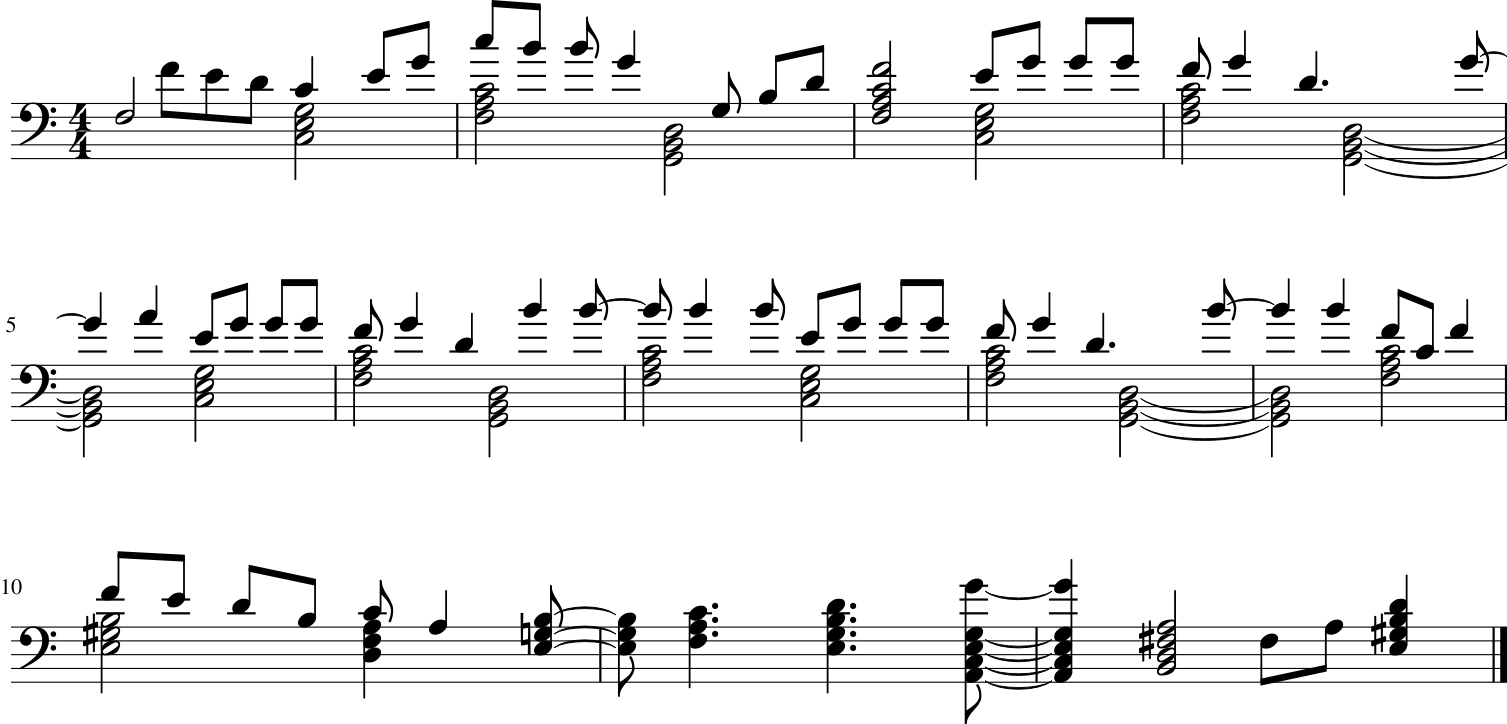

In [45]:
stream = npenc2stream(to_double_stream(out_s))
stream.show()

In [46]:
stream.show('midi')

## Predict Seq2Seq

In [47]:
csv_path = base_path/f's2s_encode/s2s_encode.csv'
csv = pd.read_csv(csv_path)
df = csv.loc[csv['numpy'].notna()];

# keywords = 'la bamba'.replace(' ', '|')
title_filter = df['title'].str.contains('la-bamba')==True
artist_filter = df['artist'].str.contains('')==True
results = df[title_filter & artist_filter]; results.head()
results = results[results.source == 'hooktheory_c']; results.head()

/home/ubuntu/anaconda3/envs/midi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (1,2,8,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,artist,section,ht_key,numpy,ht_offset,genres,title,midi,midi_title,source,parts,mxl,song_url,ht_time_signature,ht_mode,ht_bpm,md5
193183,ritchie-valen,chorus,C,sf4/s2s_encode/hooktheory/pianoroll/r/ritchie-...,0.0,"Pop,Rock",la-bamba,midi_sources/hooktheory/pianoroll/r/ritchie-va...,La Bamba,hooktheory_c,chorus,NaN,https://www.hooktheory.com/theorytab/view/ritc...,4.0,1.0,144.0,aeee134e4034e5f98bb630c56d2f7f8c


In [48]:
idx = 0
file = base_path.parent/results.numpy.values[idx];
orig = base_path.parent/results.midi.values[idx];
file, orig

(PosixPath('../../data/midi/v16/sf4/s2s_encode/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.npy'),
 PosixPath('../../data/midi/v16/midi_sources/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.mid'))

In [49]:
melody_np, chord_np = np.load(file, allow_pickle=True)

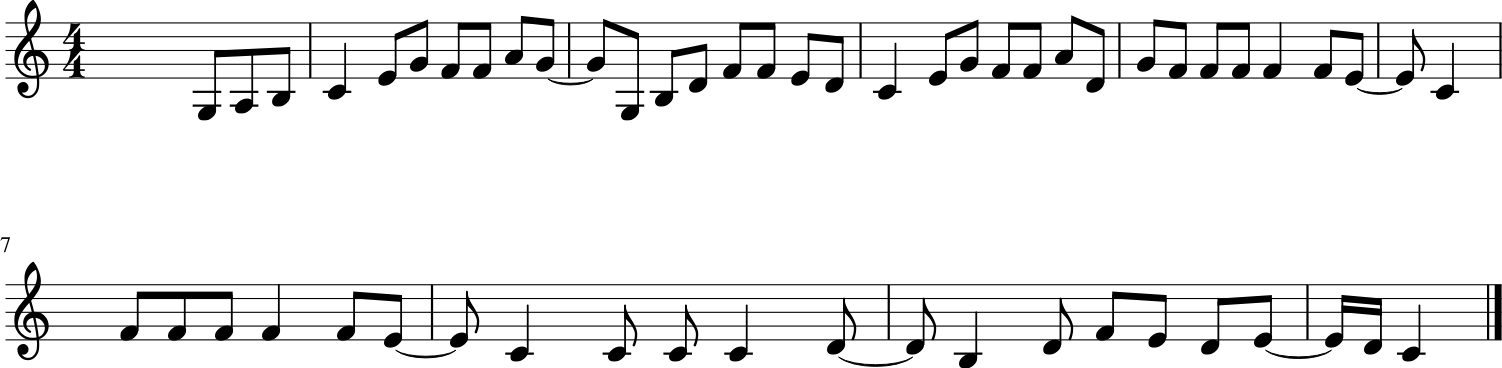

In [50]:
npenc2stream(melody_np).show()

In [54]:
def partenc2seq2seq(part_np, part_type=MSEQ, vocab=vocab, bptt=512, translate=False):
    part_meta = np.array([vocab.stoi[part_type], vocab.stoi[avg_tempo(part_np)]])
    s2s_out = to_single_stream(part_np, start_seq=part_meta)
    if translate:
        s2s_out = np.pad(s2s_out, (1,bptt), 'constant', constant_values=(vocab.stoi[CLS], vocab.pad_idx))[:bptt]
    else:
        s2s_out = np.pad(s2s_out, (0,bptt), 'constant', constant_values=vocab.pad_idx)[:bptt]
    return s2s_out

In [55]:
melody_np

array([[-1, 10],
       [55,  2],
       [-1,  2],
       [57,  2],
       ...,
       [62,  1],
       [-1,  1],
       [60,  4],
       [-1,  7]])

In [56]:
chord_np

array([[-1, 16],
       [55,  8],
       [52,  8],
       [48,  8],
       ...,
       [55,  8],
       [52,  8],
       [48,  8],
       [-1,  9]])

In [72]:
def s2s_file2parts(file, pred_melody=False):
    melody_np, chord_np = np.load(file, allow_pickle=True)
    mpart = partenc2seq2seq(melody_np, part_type=MSEQ, translate=pred_melody)
    cpart = partenc2seq2seq(chord_np, part_type=CSEQ, translate=not pred_melody)
    return mpart, cpart

In [89]:
m, c = s2s_file2parts(file, pred_melody=True)

In [90]:
xb = torch.tensor(c)[None].cuda()
yb = torch.tensor(m)[None].cuda()

In [92]:

def predict_s2s(self, xb:Tensor, yb:Tensor, n_words:int=128, temperature=0.9):
    if xb.shape[0] > 1: xb = xb[0][None]
    yb_seed = yb[:, :5]
    self.model.reset()
    self.model.update_mem_len(TaskType.Seq2Seq.value)

    for i in progress_bar(range(n_words), leave=True):
        task_type = torch.full_like(xb, TaskType.Seq2Seq.value)
        pad = xb.shape[-1]-yb_seed.shape[-1]
        yb_inp = F.pad(yb_seed, (0,pad), value=vocab.pad_idx)
        
        # Next Word
        pred_idx = yb_seed.shape[-1]-1
        res = self.pred_batch(batch=((xb,task_type,yb_inp),yb_inp))[-1][0, pred_idx] # task1, task2 - (bs x ts x vocab)

        # Encoder only - nw
#         res = self.pred_batch(batch=((xb,task_type,xb),xb))[0][0, -1] # task1, task2 - (bs x ts x vocab)

        # Use first temperatures value if last prediction was duration
        res.pow_(1 / temperature)
        idx = torch.multinomial(res, 1).item()
#         idx = res.argmax()
        if idx == vocab.bos_idx | idx == vocab.stoi[EOS]: 
            print('Predicting BOS/EOS')
            break

        t_idx = torch.tensor(idx, device=xb.device).view(1, 1)
        yb_seed = torch.cat((yb_seed, t_idx), dim=-1)

    return yb_seed


In [93]:
# yb_seed = yb[:,:3]
# pad = xb.shape[-1]-yb_seed.shape[-1]

In [94]:
yb_out = predict_s2s(learn, xb, yb)

In [95]:
yb_out

tensor([[  3,   6, 298,   8, 147,  83, 139,   8, 139,  78, 141,   8, 141,  74,
         139,   8, 139,  73, 139,   8, 139,  71, 139,   8, 139,  74, 139,   8,
         139,  71, 139,   8, 139,  68, 139,   8, 141,  76, 139,   8, 139,  69,
         139,   8, 139,  78, 139,   8, 139,  71, 139,   8, 139,  76, 139,   8,
         139,  69, 139,   8, 139,  74, 141,   8, 141,  73, 141,   8, 141,  74,
         139,   8, 139,  71, 139,   8, 139,  74, 141,   8, 141,  64, 139,   8,
         139,  66, 139,   8, 139,  69, 139,   8, 139,  74, 139,   8, 139,  71,
         139,   8, 139,  68, 139,   8, 141,  71, 139,   8, 139,  66, 139,   8,
         139,  69, 139,   8, 141,  74, 139,   8, 139,  71, 139,   8, 141,  68,
         139,   8, 143,  68, 139,   8, 139]], device='cuda:0')

In [96]:
yb_npenc = to_double_stream(yb_out.cpu().numpy()[:,1:])

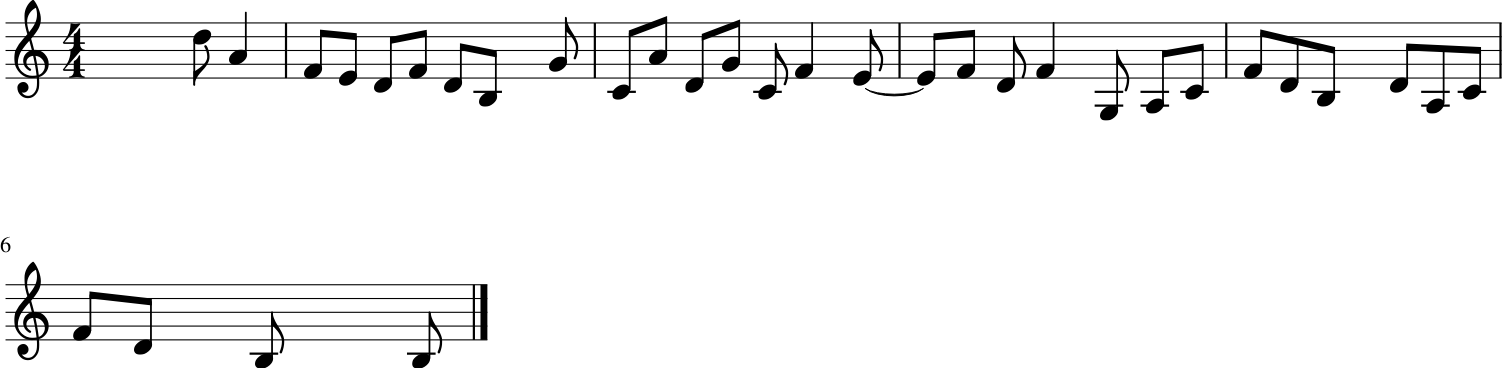

In [97]:
npenc2stream(yb_npenc).show()

In [107]:
npenc2stream(yb_npenc).show('midi')

In [102]:
def combined_npenc2chordarr(np1, np2):
    if len(np1.shape) == 1: np1 = to_double_stream(np1)
    if len(np2.shape) == 1: np1 = to_double_stream(np2)
    p1 = npenc2chordarr(np1)
    p2 = npenc2chordarr(np2)
    max_ts = max(p1.shape[0], p2.shape[0])
    p1w = ((0,max_ts-p1.shape[0]),(0,0),(0,0))
    p1_pad = np.pad(p1, p1w, 'constant')
    p2w = ((0,max_ts-p2.shape[0]),(0,0),(0,0))
    p2_pad = np.pad(p2, p2w, 'constant')
    chordarr_comb = np.concatenate((p1_pad, p2_pad), axis=1)
    return chordarr_comb

In [108]:
# chordarr_comb = combined_npenc2chordarr(yb_test, melody_np)
chordarr_comb = combined_npenc2chordarr(yb_npenc, chord_np)

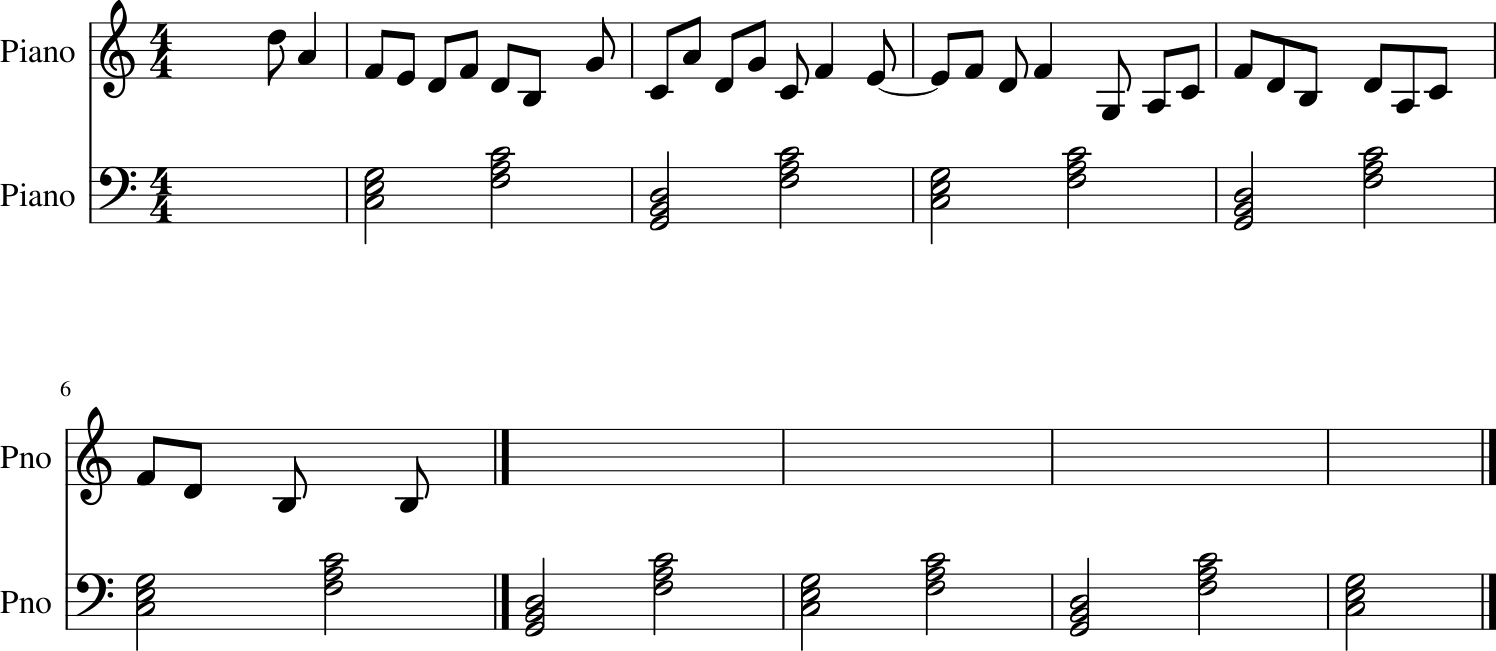

In [109]:
chordarr2stream(chordarr_comb).show()

In [110]:
chordarr2stream(chordarr_comb).show('midi')